In [1]:
inLibraries = list('rgdal','spdep','classInt','rgeos','repr', 'sp', 'dplyr', 'ggmap', 'RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           

      suppressMessages(library(rpack,character.only = TRUE))    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}

#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

Warning message:
"package 'rgdal' was built under R version 3.4.2"Warning message:
"package 'sp' was built under R version 3.4.2"Warning message:
"package 'spdep' was built under R version 3.4.2"Warning message:
"package 'classInt' was built under R version 3.4.2"Warning message:
"package 'rgeos' was built under R version 3.4.2"Warning message:
"package 'dplyr' was built under R version 3.4.2"Warning message:
"package 'ggmap' was built under R version 3.4.4"

In [2]:
# load in the Chicago polygons

chiPoly <- readOGR("data/geospatial/chicago_boundaries", 
                       "ChicagoBoundary")

OGR data source with driver: ESRI Shapefile 
Source: "data/geospatial/chicago_boundaries", layer: "ChicagoBoundary"
with 77 features
It has 9 fields


In [3]:
peekPoly <- head(chiPoly@data)
t(peekPoly)

,0,1,2,3,4,5
perimeter,0,0,0,0,0,0
community,DOUGLAS,OAKLAND,FULLER PARK,GRAND BOULEVARD,KENWOOD,LINCOLN SQUARE
shape_len,31027.05,19565.51,25339.09,28196.84,23325.17,36624.60
shape_area,46004621,16913961,19916705,48492503,29071742,71352328
area,0,0,0,0,0,0
comarea,0,0,0,0,0,0
area_numbe,35,36,37,38,39,4
area_num_1,35,36,37,38,39,4
comarea_id,0,0,0,0,0,0


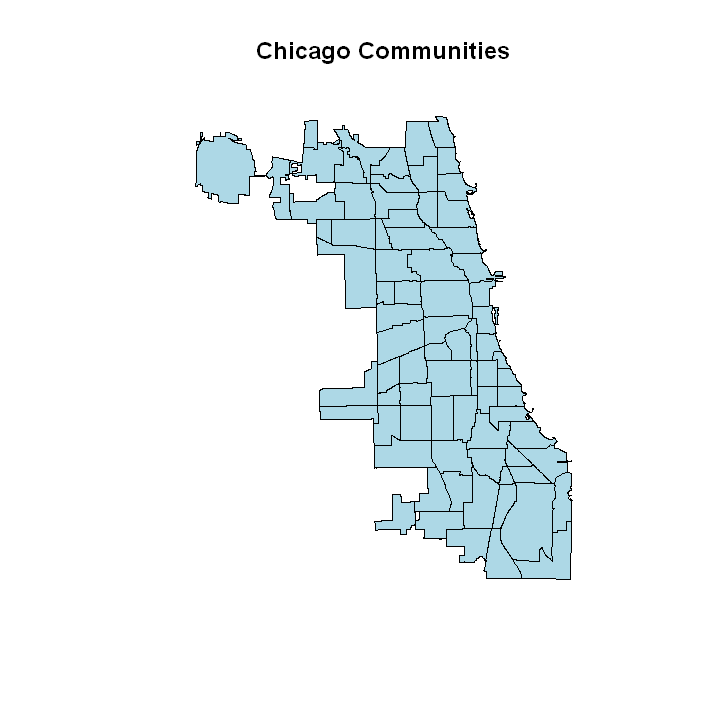

In [4]:
plot(chiPoly, 
         col = "lightblue", 
         lwd = 0.2, 
         main = "Chicago Communities")

## Load in trip and socioeconomic data

In [ ]:
# load in taxi trips with socioeconomic data

taxi <- read.csv("data/2016/trip_socioeconomic_joined.csv")

# Remove TaxiId
taxi <- taxi %>%
    select(-taxi_id)

In [ ]:
t(head(taxi, 2))

In [ ]:
nrow(taxi)

### Remove outliers

In [ ]:
summary(taxi$trip_total)

In [ ]:
tripEarningsIQR <- IQR(taxi$trip_total)

lowerQ <- quantile(taxi$trip_total)[[2]]
upperQ <- quantile(taxi$trip_total)[[4]]

upperThreshold <- (tripEarningsIQR * 1.5) + upperQ
lowerThreshold <- 1 # price cannot be lower than $1

print(upperThreshold)
print(lowerThreshold)

In [ ]:
taxi <- taxi %>% 
    filter(trip_total <= upperThreshold & trip_total >= lowerThreshold)

summary(taxi$trip_total)
print(nrow(taxi))

### Convert to spatial data

In [ ]:
# convert the long/lats to spatial point data

pickupLats <- taxi$pickup_centroid_latitude
pickupLongs <- taxi$pickup_centroid_longitude

# get other attributes
tripEarnings <- taxi$trip_total
communityAreaNumber <- taxi$CommunityAreaNumber
communityAreaName <- taxi$CommunityAreaName
percentCapitaIncome <- taxi$PercentCapitaIncome

# create dataframe
data <- data.frame(tripEarnings, percentCapitaIncome, pickupLats, pickupLongs)
head(data)

In [ ]:
# combine the x and y coordinates

ptcoords <- cbind(as.numeric(pickupLongs), as.numeric(pickupLats))
head(ptcoords)

In [ ]:
df <- SpatialPointsDataFrame(ptcoords, data = data)
head(df)

In [ ]:
# plot the points

plot(df, col = "darkred", pch = 20, cex = 0.2, lwd = 0.2, 
        main = "Taxi Pickups", cex.main = 0.8)

### Standardize the Coordinate Reference Systems (CRS)

In [ ]:
newCRS <- CRS("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0 +init=epsg:32610")

chiPoly <- spTransform(chiPoly, newCRS)
proj4string(df) <- newCRS
df <- spTransform(df, newCRS)

In [ ]:
summary(df)

In [ ]:
summary(chiPoly)

In [ ]:
plot(chiPoly, col = "lightgray", main = "Taxi Pickups", cex.main = 1, lwd = 0.2)
plot(df, col = "red", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)

In [ ]:
map <- get_map(location=rowMeans(bbox(df)), zoom = 11)

ggmap(map) + 
  geom_point(data = as.data.frame(df), 
             aes(pickupLongs, pickupLats, fill = tripEarnings), 
             color = "grey70", size = 1, shape = 21) +
  scale_fill_gradientn(colours=rev(heat.colors(5)))

###  Join the trips data with the Chicago polygon
This way, we only need to do analysis on a single set

In [ ]:
taxiSummary <- taxi %>%
    group_by(CommunityAreaNumber) %>%
    summarize(
              numberTrips = n(),
              avgTotal = mean(trip_total),
              avgTip = median(tips),
              avgFare = median(fare),
              avgMile = median(trip_miles),
              avgSeconds = median(trip_seconds),
              HardshipIndex = mean(HardshipIndex),
              PercentCapitaIncome = mean(PercentCapitaIncome),
              PercentUnder18OrOver64 = mean(PercentUnder18OrOver64),
              PercentBelowPoverty = mean(PercentBelowPoverty),
              PercentNoHsDiploma = mean(PercentNoHsDiploma),
              PercentUnemployed = mean(PercentUnemployed), 
              PercentHousingCrowded = mean(PercentHousingCrowded))

head(taxiSummary, 5)

In [ ]:
mergedPoly <- merge(x = chiPoly@data, y = taxiSummary, by.x = "area_numbe", by.y = "CommunityAreaNumber", all = TRUE)

## Let's look through the taxi data for Chicago


In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"Blues")
q <- classIntervals(mergedPoly$avgTotal, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago Taxi Trips - Average Earnings Per Trip", cex.main = 0.8)
plot(df, col = "pink", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"YlGn")
q <- classIntervals(mergedPoly$numberTrips, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago Taxi Trips - Number of Trips in 2016", cex.main = 0.8)
plot(df, col = "pink", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"Greys")
q <- classIntervals(mergedPoly$avgMile, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago Taxi Trips - Average Miles Per Trip", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

## Let's look through the socioeconomic data for Chicago

In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"Greens")
q <- classIntervals(mergedPoly$PercentCapitaIncome, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Income", cex.main = 0.8)
plot(df, col = "red", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"Reds")
q <- classIntervals(mergedPoly$HardshipIndex, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Hardship Index", cex.main = 0.8)
plot(df, col = "pink", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"Purples")
q <- classIntervals(mergedPoly$PercentBelowPoverty, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Percent Below Poverty", cex.main = 0.8)
plot(df, col = "pink", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [ ]:
numcat <- 9
pal <- brewer.pal(numcat,"Oranges")
q <- classIntervals(mergedPoly$PercentNoHsDiploma, numcat, style = "kmeans")
cols <- findColours(q, pal)

plot(chiPoly, col = cols, lwd = 0.2, main = "Chicago - Percent with No HS Diploma", cex.main = 0.8)
plot(df, col = "pink", border = "grey", add = TRUE, pch = 20, cex = 0.3, lwd = 0.3)
brks <- round(q$brks,3)
leg <- paste(brks[-numcat], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Values", cex = 0.7)

In [ ]:
# do spatial autocorrelation